In [1]:
%pylab inline

import pandas
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import math

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = open("/Users/evgeniatveritinova1/Downloads/forestfires.csv").read().split()

Посмотрим, как выглядит набор данных:

In [3]:
print data[0]

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area


Преобразуем данные в нужный нам вид:

In [4]:
data = data[1:] # убираем первую строчку в видом данных

# создаем массив размера (кол-во выборок) * размер выборки
# (размер выборки - 1), потому что мы убираем поле дня
useful_data = np.zeros(len(data) * len(data[0].split(',')))\
              .reshape(len(data), len(data[0].split(',')))

# извлекаем данные
for i in range(len(data)):
    fields = data[i].split(',') # парсим по запятой, получая поля
    
    # первые два поля без изменения
    for j in range(2):
        useful_data[i][j] = float(fields[j])
    
    # месяц преобразовываем в индикатор летнего сезона
    if fields[2] in ['jun', 'jul', 'aug']: # летние месяца
        useful_data[i][2] = 1
    else:
        useful_data[i][2] = 0
        
    #добавляем столбец единиц
    useful_data[i][3] = 1
        
    # все поля после дня оставляем без изменения
    for j in range(4, len(fields)):
        useful_data[i][j] = float(fields[j])

# напечатаем, чтобы проверить, что все хорошо    
print data[0]
print useful_data[0]

7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0,0
[  7.    5.    0.    1.   86.2  26.2  94.3   5.1   8.2  51.    6.7   0.
   0. ]


Все хорошо, данные извлеклись правильно :)

In [5]:
random.shuffle(useful_data) # перемешиваем данные

# разделяем на две части в отношении 7 : 3
frst_data = useful_data[:(len(useful_data) / 10 * 7)]
scnd_data = useful_data[len(frst_data):]

Построим регрессионную модель:

In [6]:
Z = np.matrix(frst_data.T[:-1]).T # матрица выборок первой части без area
X = np.matrix(frst_data.T[-1]).T # столбец результатов (area) первой части
est = (Z.T * Z).I * Z.T * X # полученная оценка для коэффициентов

In [7]:
s = np.matrix(scnd_data.T[:-1].T) # матрица выборок второй части без area
pred = np.array(s * est).reshape(s.shape[0]) # предсказание (area) результата второй части
real_val = scnd_data.T[-1].T # столбец результатов (area) второй части
mse = np.std(pred - real_val) # среднеквадратичная ошибка
print 'Полученная среднеквадратичная ошибка : ' + str(mse)
print 'Минимальное значение area : ' + str(real_val.min())
print 'Максимальное значение area : ' + str(real_val.max())
print 'Среднее значение area : ' + str(real_val.mean())

Полученная среднеквадратичная ошибка : 105.231901288
Минимальное значение area : 0.0
Максимальное значение area : 1090.84
Среднее значение area : 19.72525


Среднеквадратичная ошибка достаточно сильно отличается от среднего значения

In [8]:
def get_mse(c):
    # обновляем данные, чтобы корректно работало после перемешивания данных(см. далее)
    # разделяем на две части в отношении 7 : 3
    frst_data = useful_data[:(len(useful_data) / 10 * 7)]
    scnd_data = useful_data[len(frst_data):]
    Z = np.matrix(frst_data.T[:-1]).T # матрица выборок первой части без area
    X = np.matrix(frst_data.T[-1]).T # столбец результатов (area) первой части
    s = np.matrix(scnd_data.T[:-1].T) # матрица выборок второй части без area
    real_val = scnd_data.T[-1].T # столбец результатов (area) второй части
    
    changed_X = np.matrix(np.array([math.log(c + x[0]) for x in X]).reshape(X.shape)) # применяем к area пребразование
    new_est = (Z.T * Z).I * Z.T * changed_X # считаем оценку для преобразованных данных 
    new_pred = np.array(s * new_est)
    changed_real_val = np.array([math.log(c + x) for x in real_val]).reshape(real_val.shape)
    # Cреднеквадратичная ошибка для преобразованных значений
    mse1 = np.std(new_pred - changed_real_val)
    # Cреднеквадратичная ошибка для исходных, применив к оценкам обратное преобразование
    mse2 = np.std([e**x - c for x in new_pred] - real_val)
    return (mse1, mse2)

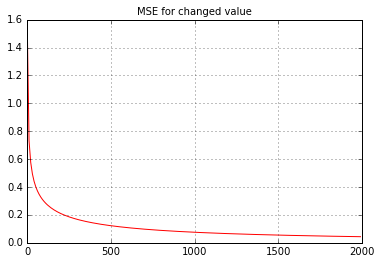

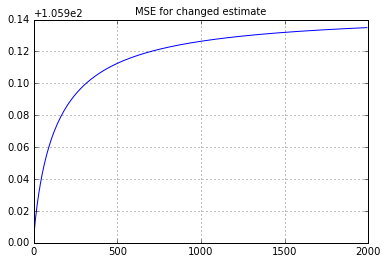

In [9]:
grid = np.arange(1, 2000, 10)
mse = [get_mse(x)[0] for x in grid]
plt.plot(grid, mse, color='red')
plt.title("MSE for changed value", fontsize=10)
plt.grid(True)
plt.show()
mse = [get_mse(x)[1] for x in grid]
plt.plot(grid, mse, color='blue')
plt.title("MSE for changed estimate", fontsize=10)
plt.grid(True)
plt.show()

Чем больше c, тем меньше ошибка для преобразованных значений, но для исходных значений с преобразованными предсказаниями ошибка увеличивается. Возьмем очень маленькое с.

In [10]:
c = 1e-9
test_cnt = 100
errors = np.zeros(test_cnt)
for i in range(test_cnt):
    random.shuffle(useful_data)
    errors[i] = get_mse(c)[1]

print('Средняя ошибка: ' + str(errors.mean()))
print('Минимальная ошибка: ' + str(errors.min()))
print('Максимальная ошибка: ' + str(errors.max()))

Средняя ошибка: 55.1154579305
Минимальная ошибка: 14.47776403
Максимальная ошибка: 107.862609738
